# COGS 182 Project 1
## Blackjack Learning Agent Comparison
#### Malachi Mabie
20 Feb 2021

## 1. Implementation



> Code run through Google Colab. Nothing besides this jupyter notebook is needed in order to run. Test and plot files are automatically saved to a runtime folder, which may be downloaded for safekeeping.



#### Imports

In [ ]:
# standard
import numpy as np
import matplotlib.pyplot as plt

# non-standard
from tqdm import tqdm  # wraps iterables to make progress bars
from mpl_toolkits.mplot3d import Axes3D # 3D axes for surface plot

#### Game Mechanic Functions

In [ ]:
# Randomly draw card (unif number, 2/3 black color) from deck.
def draw():
  number = np.random.randint(low=1,high=11) # unif 1-10
  color = np.random.choice(['red','black'],p=[1/3,2/3]) # 1/3 red 2/3 black
  return number, color

In [ ]:
# Return sample outcome from state and action pair.
#   state is comprised of dealer's observed card and the player sum. 
#   action = hit or stick
#   s = [dealer card, player count]
def step(s,a):
  # dealer sum is comprised of single observed black card from game's start.
  dsum, sum = s
  number, color = draw()
  # HIT
  if a == 'hit':
    # next sum state
    if color == 'red':
      sum -= number
    else:
      sum += number

    # player going bust
    if sum < 0 or sum > 21:
      return 'terminal', -1

    # game continues
    return dsum, sum, 0

  # STICK
  while (dsum >= 0 and dsum < 17):
    if color == 'red':
      dsum -= number
    else:
      dsum += number
    number, color = draw()

  # dealer going bust
  if dsum < 0 or dsum > 21:
    return 'terminal', 1

  # game ending by sum
  if sum > dsum: return 'terminal', 1
  if sum == dsum: return 'terminal', 0
  return 'terminal', -1

#### Frequency Test Functions

In [ ]:
# creates file displaying draw frequencies.
#   each line shows card, color, and frequency.
def checkDraw():
  lines = np.zeros((20,3))
  # i originally inserted by card number.
  for i in range(1,20,2):
    # red=-1, black=+1
    lines[i-1] = [i//2 + 1,1,0]
    lines[i] = [i//2 + 1,-1,0]

  for i in tqdm(range(1,1001)):
    number, color = draw()
    index = 2*number - 1
    if (color == 'black'): index -= 1
    lines[int(index), 2] += 1

  lines[:,2] /= 1000
  # sort by frequency
  lines = lines[np.argsort(-1*lines[:, 2])]

  np.savetxt("checkDraw", lines, fmt='%d,%d,%f')

In [ ]:
# check frequencies of card draws
checkDraw()

100%|██████████| 1000/1000 [00:00<00:00, 18372.06it/s]


In [ ]:
# creates file displaying result frequencies of one state-action pair.
#   filename shows dealer hand, player count, and action choice.
#   each line shows dealer card, player sum, reward, and frequency.
def checkStep(s,a):
  # hit=0, stick=1
  action = 0 if a == 'hit' else 1
  # filename
  name = f'checkStepDealer{s[0]}Player{s[1]}Action{action}'
  sample = []
  freq = []

  # find frequencies within 1000 runs.
  for i in tqdm(range(1,1001)):
    result = step(s,a)
    try:
      row = sample.index(result)
      # if index exists, increment frequency.
      freq[row] += 1
    except ValueError:
      # otherwise add new row.
      sample.append(result)
      freq.append(1)

  # terminal results are encoded as (0,0,reward).
  for i, r in enumerate(sample):
    if r[0] == 'terminal':
      sample[i] = (0,0,r[1])

  # finalize single array of results
  freq = np.array(freq) / 1000
  sample = np.column_stack((np.array(sample), freq))
  # sort by frequency
  sample = sample[np.argsort(-1*sample[:, 3])]

  # make file from array
  np.savetxt(name, sample, fmt='%d,%d,%d,%f')

In [ ]:
# create freq files for these state-action pairs:  
checkStep([1,1],'hit')
checkStep([2,10],'hit')
checkStep([1,18],'stick')
checkStep([10,15],'stick')

100%|██████████| 1000/1000 [00:00<00:00, 6498.29it/s]


## 2. Monte-Carlo Control

#### Algorithm

In [ ]:
def montecarlo(num_eps=1000000):
  print_at = [num_eps]
  # 22 possible player states, 10 possible dealer starts.
  Q = np.zeros((10,22,2)) # one value per state-action pair

  # N[dsum,sum,action] = frequency. num visits per state-action pair.
  # hit is action indice 0, stick is action indice 1.
  N = np.zeros((10,22,2))

  # get good estimate of Q* from 1 million episodes
  for i in tqdm(range(num_eps+1)):
    # draw black card for dealer and for player
    sum = np.random.randint(low=1,high=11)
    dsum = np.random.randint(low=1,high=11)

    # step through episode
    while True:
      # policy: epsilon-greedy
      p = np.random.random()
      # epsilon formula
      N0 = 10
      epsilon = N0 / (N0 + np.amin(N[dsum - 1,sum]))
      if p < epsilon:
        # random
        action = round(p)
      else:
        action = np.argmax(Q[dsum - 1][sum])

      # update N
      N[dsum - 1, sum, action] += 1
      # get step return
      result = step([dsum,sum],'hit' if action == 0 else 'stick')

      if result[0] == 'terminal':
        # formula for step size alpha
        alpha = 1 / N[dsum - 1, sum, action]
        # update Q using step size to average returns
        Q[dsum-1,sum,action] += alpha*(result[1] - Q[dsum-1,sum,action])
        break
      # otherwise, update the player sum and continue
      sum = result[1]

    # track the optimal value function V*(s) = max_a Q*(s,a)
    if i in print_at:     
      V = np.amax(Q,axis=2)


  # parse 3D array into list
  checkQ = []
  it = np.nditer(Q, flags=['multi_index'], order='C')
  for value in it:
    dsum = it.multi_index[0] + 1
    sum = it.multi_index[1]
    action = it.multi_index[2]
    # dsum, sum, action, action value
    checkQ.append((dsum,sum,action,value))
  
  # return estimate of Q* to a test file
  np.savetxt('checkQ', np.array(checkQ), fmt='%d,%d,%d,%f')

  return V


In [ ]:
V = montecarlo(5000000)
%store V

100%|██████████| 5000001/5000001 [20:11<00:00, 4128.55it/s]

Stored 'V' (ndarray)


#### Optimal Value Function Plot

In [1]:
def plotV(V, filename='valuePlot.png',
          title='Optimal Value after 5,000,000 episodes'):
  it = np.nditer(V, flags=['multi_index'])
  values = []
  for z in it:
    x = it.multi_index[0] + 1
    y = it.multi_index[1]
    # x, y, z
    values.append((x,y,z.item(0)))
  values = np.array(values).T
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  surf=ax.plot_trisurf(values[0],values[1],values[2],cmap=plt.cm.copper)
  plt.xlabel("Dealer Card")
  plt.ylabel("Player Sum")
  plt.title(title)
  plt.savefig(filename)
  plt.show()

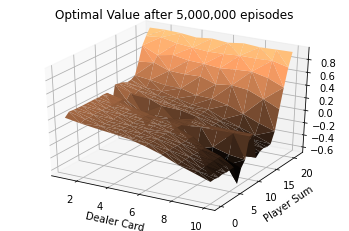

In [ ]:
plotV(V)


## 3. TD Learning

#### Sarsa(0) Algorithm

In [ ]:
def sarsazero(num_eps=10000,gamma=1):
  print_at = [num_eps]
  # 22 possible player states, 10 possible dealer starts.
  Q = np.zeros((10,22,2)) # abitrarily setting all Q to zero...
  N0 = 10

  # use checkQ as error check for learning curve
  monteQ = np.loadtxt('checkQ', delimiter=',').T[3]
  l_curve = np.empty(num_eps+1)

  # N[dsum,sum,action] = frequency. num visits per state-action pair.
  N = np.zeros((10,22,2))

  # bootstrap from 10 thousand episodes.
  for i in tqdm(range(num_eps+1)):
    # Initialize S
    sum = np.random.randint(low=1,high=11)
    dsum = np.random.randint(low=1,high=11)

    # Choose A from S using Q-derived epsilon-greedy policy
    p = np.random.random()
    # epsilon formula
    epsilon = N0 / (N0 + np.amin(N[dsum - 1,sum]))
    if p < epsilon:
      # random
      action = round(p)
    else:
      action = np.argmax(Q[dsum - 1][sum])
                         
    # step through episode
    while True:
      # take action A, observe R, S'
      result = step([dsum,sum],'hit' if action == 0 else 'stick')
      N[dsum - 1, sum, action] += 1
      alpha = 1 / N[dsum-1, sum, action]

      if result[0] == 'terminal':
        reward = result[1]
        # same Q update as monte carlo
        Q[dsum-1,sum,action] += alpha*(reward - Q[dsum-1,sum,action])
        break

      sum_n = result[1]
      # choose A' from S' using Q-derived policy
      p = np.random.random()
      # epsilon formula
      epsilon = N0 / (N0 + np.amin(N[dsum - 1,sum_n]))
      if p < epsilon:
        # random
        act_n = round(p)
      else:
        act_n = np.argmax(Q[dsum - 1][sum_n])
        
      # update Q of the original state using gamma*Q[S',A'] too!
      Q[dsum-1,sum,action] += alpha*(gamma*Q[dsum-1,sum_n,act_n] 
                                     - Q[dsum-1,sum,action])
      # update state and action to equal S' and A' and repeat.
      sum = sum_n
      action = act_n

    # track the mean-squared error monte carlo's Q and this one
    l_curve[i] = ((monteQ.T[3] - Q.flatten()) ** 2).mean()

    # track the optimal value function V*(s) = max_a Q*(s,a)
    if i in print_at:     
      V = np.amax(Q,axis=2)

  return l_curve, V


In [ ]:
l_curve, V_td = sarsazero()

100%|██████████| 10001/10001 [00:02<00:00, 3437.71it/s]


#### Learning Curve Plot

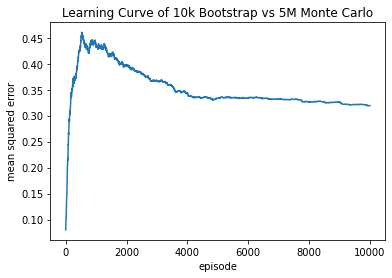

In [ ]:
plt.plot(l_curve)
plt.xlabel("episode")
plt.ylabel("mean squared error")
plt.title("Learning Curve of 10k Bootstrap vs 5M Monte Carlo")
plt.savefig("learningCurve.png")
plt.show()

#### TD Value Function Plot

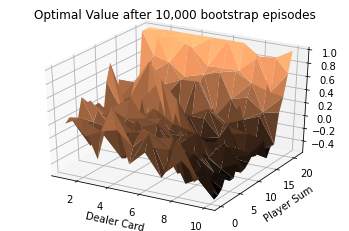

In [ ]:
plotV(V_td,filename="TD_valuePlot.png",title="Optimal Value after 10,000 bootstrap episodes")

## 4. Discussion

#### What are the pros and cons of bootstrapping in this game?


> The pro is that it takes much fewer episodes to get in the ballpark of predictive values. The con is that it bootstraps using early biases that are founded on too few random samples to be a representative weight.




#### Would you expect bootstrapping to help more in standard blackjack or this game? Why?


> The standard blackjack game introduces more uncertainty and higher valued cards. It also does not use an infinite deck. I expect bootstrapping to usually help less, and sometimes help more. Since the environment is further away from one habitable to the dynamic programming methods bootstrapping imitates, it will exaggerate.